In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

In [2]:

# labels - age, gender, ethnicity
data_dir = 'UTKFace'
images = []
age_labels = []
gender_labels = []
race_labels = []

for filename in os.listdir(data_dir):
    if filename.endswith('.jpg'):
        # Split the filename
        parts = filename.split('_')
        if len(parts) != 4:
            # Skip files that don't have all four expected parts
            continue
        age, gender, race, _ = parts
        try:
            age = float(age)
            gender = int(gender)
            race = int(race)
        except ValueError:
            # Skip files with non-numeric labels
            continue
        # Add image path and corresponding labels to lists
        image_path = os.path.join(data_dir, filename)
        images.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)
        race_labels.append(race)
                
# Verify the updated data
print("Total images:", len(images))
print("Total age labels:", len(age_labels))
print("Total gender labels:", len(gender_labels))
print("Total race labels:", len(race_labels))

Total images: 23705
Total age labels: 23705
Total gender labels: 23705
Total race labels: 23705


In [3]:
# convert to dataframe

import pandas as pd
df = pd.DataFrame()
# df['image'], df['age'], df['gender'] = images, age_labels, gender_labels
df['image'], df['age'] = images, age_labels
df.head()

,image,age
0,UTKFace\100_0_0_20170112213500903.jpg.chip.jpg,100.0
1,UTKFace\100_0_0_20170112215240346.jpg.chip.jpg,100.0
2,UTKFace\100_1_0_20170110183726390.jpg.chip.jpg,100.0
3,UTKFace\100_1_0_20170112213001988.jpg.chip.jpg,100.0
4,UTKFace\100_1_0_20170112213303693.jpg.chip.jpg,100.0


<Figure size 700x600 with 0 Axes>

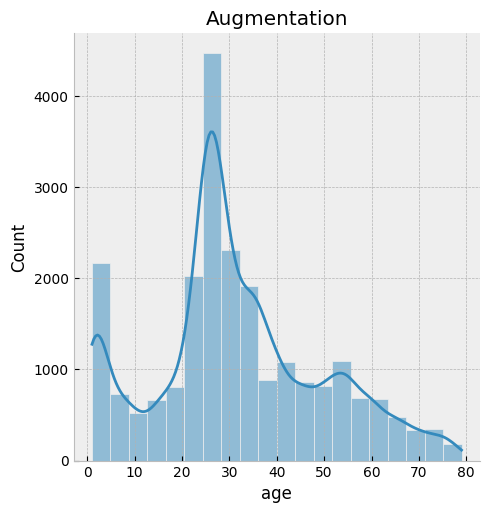

In [4]:
# Set the size of the figure
plt.style.use('bmh')
plt.figure(figsize=(7, 6))  # Set the size to 8 inches wide and 6 inches tall

df = df[df['age'] < 80]
sns.displot(df['age'],kde=True, bins=20)
plt.title('Augmentation')
# Show the plot

plt.show()

In [5]:
df, test_df = train_test_split(df, test_size=0.15, stratify=df['age'])
# df = df.reset_index(drop=True)
print(len(test_df))
print(len(df))

3455
19577


In [6]:
condition = (df['age'] > 31) | (df['age'] < 21)

# use boolean indexing to filter the rows and duplicate them twice
duplicated_rows = df[condition].copy()
duplicated_twice = pd.concat([duplicated_rows, duplicated_rows])

# concatenate the original dataframe and the duplicated rows twice
df = pd.concat([df, duplicated_twice], ignore_index=True)

df.head()

,image,age
0,UTKFace\60_1_0_20170110140707890.jpg.chip.jpg,60.0
1,UTKFace\35_0_0_20170117180401255.jpg.chip.jpg,35.0
2,UTKFace\75_1_1_20170105003534605.jpg.chip.jpg,75.0
3,UTKFace\35_0_0_20170117152248499.jpg.chip.jpg,35.0
4,UTKFace\35_0_0_20170117191433859.jpg.chip.jpg,35.0


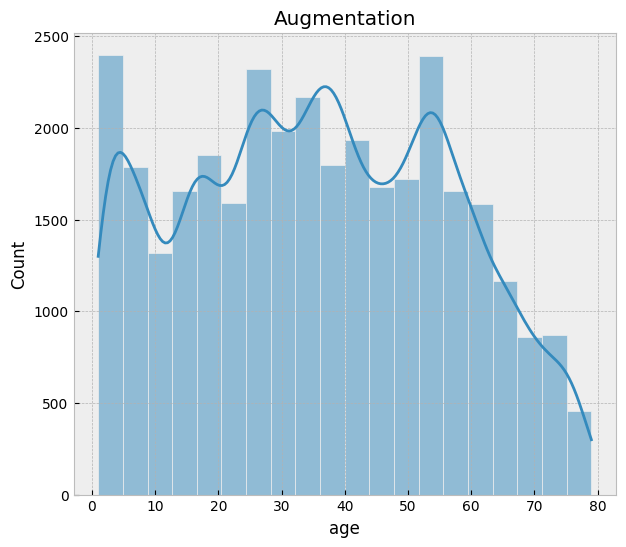

33193
36648


In [7]:

# Count the number of images per age
image_counts = df['age'].value_counts()

cut_off = 600

# Remove images with counts exceeding 280
for age, count in image_counts.items():
    if count > cut_off:
        excess_images = df[df['age'] == age].sample(count - cut_off)
        df = df.drop(excess_images.index)
df = df.reset_index(drop=True)

# Set the size of the figure
plt.style.use('bmh')
plt.figure(figsize=(7, 6))  # Set the size to 8 inches wide and 6 inches tall

# Create the histogram with KDE using seaborn
sns.histplot(df['age'], kde=True, bins=20)
plt.title('Augmentation')
# Show the plot

plt.show()
print(len(df))
print(len(df) + len(test_df))

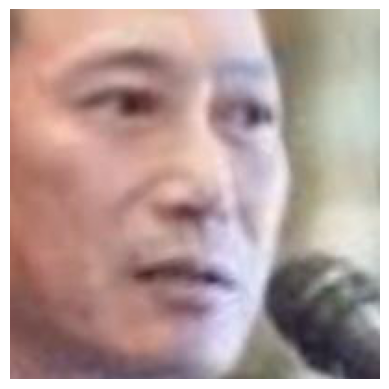

In [8]:
from PIL import Image
img = Image.open(df['image'][30000])
plt.axis('off')
plt.imshow(img);

In [12]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import random
from PIL import ImageEnhance
import torchvision.transforms.functional as TF


class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path, age = self.dataframe.iloc[index]
        image = Image.open(image_path)
        image = self.transform(image)
        if image.shape[1] == 1:
            # If image has only 1 channel, expand tensor along channel dimension
            image = torch.cat([image]*3, dim=1)
        label_tensor = torch.tensor(age)
        return image, label_tensor



train_df, valid_df = train_test_split(df, test_size=0.1, stratify=df['age'])
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


# Define transformations for train, validation, and test sets
transform_train = transforms.Compose([
#      transforms.RandomCrop(180),
    transforms.Resize((224, 224), antialias=True),  # Resize the image with antialiasing
    # transforms.Grayscale(),  # Convert the image to grayscale
    transforms.RandomRotation(10),
#     transforms.Lambda(lambda x: ImageEnhance.Contrast(x).enhance(0.5)),  # Increase contrast
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])


transform_test = transforms.Compose([
    # transforms.Grayscale(), 
    transforms.Resize((224, 224), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

# Create the datasets
train_dataset = CustomDataset(train_df, transform=transform_train)
valid_dataset = CustomDataset(valid_df, transform=transform_train)
test_dataset = CustomDataset(test_df, transform=transform_test)


# Create data loaders
batch_size = 32


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [13]:
df

,image,age
0,UTKFace\60_1_0_20170110140707890.jpg.chip.jpg,60.0
1,UTKFace\35_0_0_20170117180401255.jpg.chip.jpg,35.0
2,UTKFace\75_1_1_20170105003534605.jpg.chip.jpg,75.0
3,UTKFace\35_0_0_20170117152248499.jpg.chip.jpg,35.0
4,UTKFace\35_0_0_20170117191433859.jpg.chip.jpg,35.0
...,...,...
33188,UTKFace\32_0_2_20170116184944206.jpg.chip.jpg,32.0
33189,UTKFace\33_1_0_20170105161501346.jpg.chip.jpg,33.0
33190,UTKFace\37_0_0_20170116200645679.jpg.chip.jpg,37.0
33191,UTKFace\19_1_0_20170105183247775.jpg.chip.jpg,19.0


In [14]:
test_df.head()


,image,age
0,UTKFace\35_0_0_20170105172523741.jpg.chip.jpg,35.0
1,UTKFace\35_1_4_20170113182827279.jpg.chip.jpg,35.0
2,UTKFace\60_0_3_20170117175443809.jpg.chip.jpg,60.0
3,UTKFace\31_1_4_20170103230330201.jpg.chip.jpg,31.0
4,UTKFace\70_1_3_20170109134219121.jpg.chip.jpg,70.0


In [18]:
import torch
# GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [19]:
import torch.nn as nn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 80)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net()
model.to(device) 


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=80, bias=True)
)

In [20]:
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {n_params:,}')

Total number of parameters: 12,860,592


In [21]:
import torch.optim as optim

In [24]:
# Check the number of channels in the train loader
sample_batch = next(iter(train_loader))
sample_images, _ = sample_batch  # Assuming the images are in the first element of each batch

# Check the shape of the sample image
print(sample_images.shape)  # The shape will be in the format: (batch_size, channels, height, width)

num_channels = sample_images.shape[1]
print(f"Number of channels: {num_channels}")


sample_batch = next(iter(train_loader))
sample_images, _ = sample_batch

# Check the minimum and maximum pixel values in the sample images
min_value = sample_images.min().item()
max_value = sample_images.max().item()

print(f"Minimum pixel value: {min_value}")
print(f"Maximum pixel value: {max_value}")
print(len(train_loader)*batch_size)


torch.Size([32, 3, 224, 224])
Number of channels: 3
Minimum pixel value: -2.1179039478302
Maximum pixel value: 2.640000104904175
29888


In [25]:
import math
import wandb

In [26]:
data_iter = iter(train_loader)
inputs,labels = next(data_iter)

In [27]:
sweep_config = {
    'method': 'random', 
    'metric': {
        'name': 'val/val_accuracy', 
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'values': [100]},
        'batch_size': {'values': [32]},
        'dropout': {'values': [0.5]},
        'lr': {'values': [0.001]},
    }
}

# 🐝 Sweep over hyperparameters
sweep_id = wandb.sweep(sweep_config, project="CNN80classes")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 1wk1l8ga
Sweep URL: https://wandb.ai/592/CNN80classes/sweeps/1wk1l8ga


In [28]:
def log_image_table(images, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # 🐝 Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=["image", "pred", "target"]+[f"score_{i}" for i in range(80)])
    for img, pred, targ, prob in zip(images.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

In [29]:
def validate_model(model, valid_dl, loss_func, log_images=False, batch_idx=0):
    model.eval()
    val_loss = 0.
    with torch.inference_mode():
        correct = 0
        for i, (images, labels) in enumerate(valid_dl):
            images, labels = images.to(device), labels.to(device)
            labels = torch.tensor(labels, dtype=torch.long)
            # outputs = torch.tensor(outputs, dtype=torch.long)
            # Forward pass ➡
            outputs = model(images)
            val_loss += loss_func(outputs, labels)*labels.size(0)

            # Compute accuracy and accumulate
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            # Log one batch of images to the dashboard, always same batch_idx.
            if i==batch_idx and log_images:
                log_image_table(images, predicted, labels, outputs.softmax(dim=1))
    return val_loss / len(valid_dl.dataset), correct / len(valid_dl.dataset)


In [30]:
history_dense = {'accuracy': [], 'val_accuracy': []}
def train():
    example_ct = 0
    wandb.init()
    config = wandb.config

    # note that we define values from `wandb.config`  
    # instead of defining hard values
    lr  =  config.lr
    bs = config.batch_size
    epochs = config.epochs
    dropout= config.dropout
    n_steps_per_epoch = math.ceil(len(train_dataset) / bs)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = torch.tensor(labels, dtype=torch.long)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.to(device)
            labels = torch.tensor(labels, dtype=torch.long)
            # outputs = torch.tensor(outputs, dtype=torch.long)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            example_ct += len(inputs)
            metrics = {"train/train_loss": loss, 
                        "train/epoch": (i + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch, 
                        "train/example_ct": example_ct,
                        "ecoph": epoch}
            if i + 1 < n_steps_per_epoch:
                # 🐝 Log train metrics to wandb 
                wandb.log(metrics)
            
            if (i + 1) % 100 == 0 or (i + 1) == len(train_loader):
                acc = 100 * correct / total
                correct_val = 0
                total_val = 0
                with torch.no_grad():
                    for data in val_loader:
                        inputs, labels = data
                        inputs = inputs.to(device)
                        labels = torch.tensor(labels).to(device)
                        outputs = model(inputs.float())
                        _, predicted = torch.max(outputs.data, 1)
                        total_val += labels.size(0)
                        correct_val += (predicted == labels).sum().item()
                val_acc = 100 * correct_val / total_val
                # history_dense['accuracy'].append(acc)
                # history_dense['val_accuracy'].append(val_acc)
                print('[%d, %5d/%d] loss: %.3f accuracy: %.3f val_accuracy: %.3f' %
                    (epoch + 1, i + 1, len(train_loader), running_loss / 100, acc, val_acc))
                wandb.log({"Acc": acc,
                           "ecoph": epoch})
                running_loss = 0.0
                correct = 0
                total = 0
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, log_images=(epoch==(config.epochs-1)))
        val_metrics = {"val/val_loss": val_loss, 
                    "val/val_accuracy": val_accuracy,
                    "ecoph": epoch}
        wandb.log({**metrics, **val_metrics})
        print(f"Train Loss: {loss:.3f}, Valid Loss: {val_loss:3f}, Val_Accuracy: {val_accuracy:.2f}")
        # save train and validation accuracy for current epoch
        history_dense['accuracy'].append(acc)
        history_dense['val_accuracy'].append(val_acc)

    wandb.finish()
wandb.agent(sweep_id, function=train, count=1)

wandb: Agent Starting Run: c5j8ojl7 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	epochs: 100
wandb: 	lr: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shiyong (592). Use `wandb login --relogin` to force relogin


C:\Users\qisai\AppData\Local\Temp\ipykernel_3400\1217885382.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
C:\Users\qisai\AppData\Local\Temp\ipykernel_3400\1217885382.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
C:\Users\qisai\AppData\Local\Temp\ipykernel_3400\1217885382.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


[1,   100/934] loss: 4.509 accuracy: 1.625 val_accuracy: 1.898
[1,   200/934] loss: 4.315 accuracy: 2.375 val_accuracy: 2.590
[1,   300/934] loss: 4.264 accuracy: 3.125 val_accuracy: 3.193
[1,   400/934] loss: 4.203 accuracy: 3.062 val_accuracy: 3.614
[1,   500/934] loss: 4.130 accuracy: 3.250 val_accuracy: 3.133
[1,   600/934] loss: 4.118 accuracy: 3.656 val_accuracy: 3.193
[1,   700/934] loss: 4.082 accuracy: 2.906 val_accuracy: 3.825
[1,   800/934] loss: 4.050 accuracy: 3.688 val_accuracy: 4.066
[1,   900/934] loss: 4.047 accuracy: 3.906 val_accuracy: 4.096
[1,   934/934] loss: 1.352 accuracy: 4.660 val_accuracy: 4.217


C:\Users\qisai\AppData\Local\Temp\ipykernel_3400\671948862.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


Train Loss: 3.748, Valid Loss: 3.920199, Val_Accuracy: 0.06
[2,   100/934] loss: 3.779 accuracy: 6.312 val_accuracy: 6.235
[2,   200/934] loss: 3.695 accuracy: 6.156 val_accuracy: 6.536
[2,   300/934] loss: 3.632 accuracy: 6.719 val_accuracy: 6.596
[2,   400/934] loss: 3.609 accuracy: 7.438 val_accuracy: 7.169
[2,   500/934] loss: 3.547 accuracy: 7.281 val_accuracy: 7.410
[2,   600/934] loss: 3.494 accuracy: 8.750 val_accuracy: 7.560
[2,   700/934] loss: 3.519 accuracy: 7.844 val_accuracy: 8.554
[2,   800/934] loss: 3.465 accuracy: 8.438 val_accuracy: 7.922
[2,   900/934] loss: 3.467 accuracy: 8.906 val_accuracy: 8.373
[2,   934/934] loss: 1.185 accuracy: 8.108 val_accuracy: 9.398
Train Loss: 3.655, Valid Loss: 3.412658, Val_Accuracy: 0.09
[3,   100/934] loss: 3.402 accuracy: 8.875 val_accuracy: 8.253
[3,   200/934] loss: 3.381 accuracy: 9.406 val_accuracy: 8.886
[3,   300/934] loss: 3.378 accuracy: 8.250 val_accuracy: 8.855
[3,   400/934] loss: 3.352 accuracy: 9.875 val_accuracy: 8.31

Acc,▁▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██▇█
ecoph,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/train_loss,█▇▆▆▅▆▅▅▅▄▃▃▅▄▄▄▄▄▃▃▃▃▄▂▃▃▃▁▃▃▃▃▂▂▃▃▃▂▃▃
val/val_accuracy,▁▂▂▃▃▃▄▄▄▅▅▅▆▆▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇██████
val/val_loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁▁▂▁▂▁▁▂▂▂▁▂▂▁▂
Acc,44.17521
ecoph,99
train/epoch,99.99893
train/example_ct,2987283


Run c5j8ojl7 errored: ValueError("This table expects 7 columns: ['image', 'pred', 'target', 'score_0', 'score_1', 'score_2', 'score_3'], found 83")
wandb: ERROR Run c5j8ojl7 errored: ValueError("This table expects 7 columns: ['image', 'pred', 'target', 'score_0', 'score_1', 'score_2', 'score_3'], found 83")


In [34]:
torch.save(model.state_dict(), 'cnn80.pt')

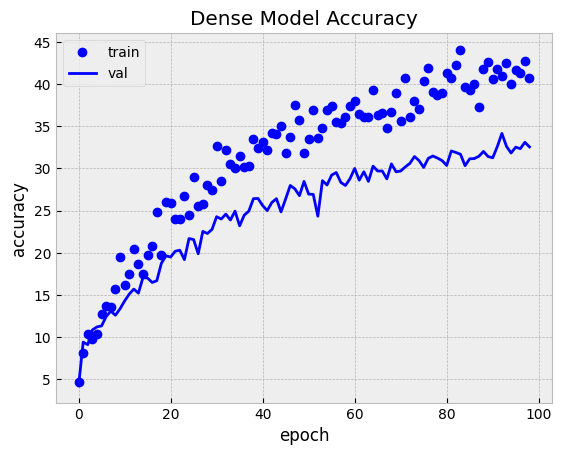

In [35]:
plt.plot(history_dense['accuracy'], 'bo')
plt.plot(history_dense['val_accuracy'], 'b')
plt.title('Dense Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
model.eval()  
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print('Test Accuracy: %.3f %%' % (test_acc))

Test Accuracy: 9.001 %
